# Grid-Based Stop Detection

The stop detection algorithms implemented in `nomad` support different combinations of input formats that are common in commercial datasets, detecting default names when possible
- timestamps in `datetime64[ns, tz]` or as unix seconds in integers
- geographic coordinates (`lon`, `lat`) which use the Haversine distance or projected coordinates (`x`, `y`) using meters and euclidean distance.
- Alternatively, if locations are only given through a spatial index like H3 or geohash, there is a **grid_based** clustering algorithm requiring no coordinates. 

The algorithms work with the same call, provided there is at least a pair of coordinates (or a location/spatial index) as well as at least a temporal column.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Imports
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import box
from nomad.stop_detection.viz import plot_stops_barcode, plot_time_barcode, plot_hexagons, plot_pings
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters 

# Load data
import nomad.data as data_folder
from pathlib import Path
data_dir = Path(data_folder.__file__).parent
city = gpd.read_parquet(data_dir / 'garden-city-buildings-mercator.parquet')
outer_box = box(*city.total_bounds)

filepath_root = 'gc_data_long/'
tc = {"user_id": "gc_identifier", "x": "dev_x", "y": "dev_y", "timestamp": "unix_ts"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters=('date','==', '2024-01-01'), traj_cols=tc)

# Grid-based - data is in Web Mercator (EPSG:3857) projected coordinates
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=11, traj_cols=tc, data_crs='EPSG:3857')
stops_gb = GRID_BASED.grid_based(traj, time_thresh=240, complete_output=True, location_id='h3_cell', traj_cols=tc)

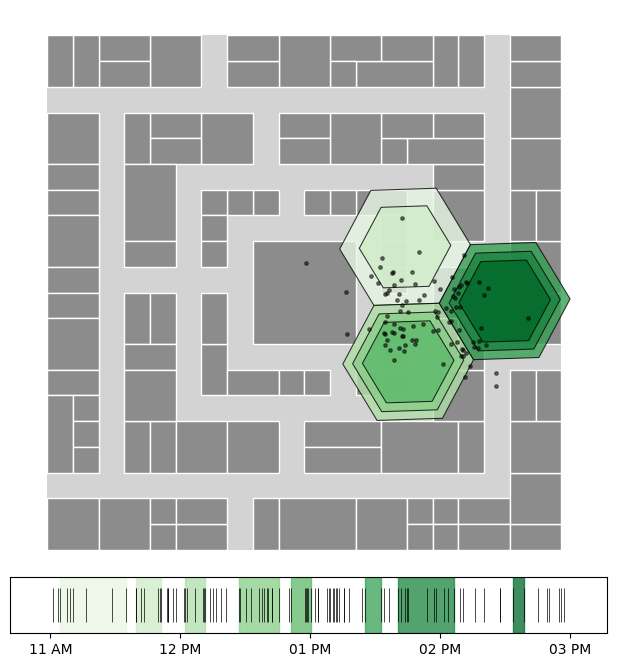

In [2]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

gpd.GeoDataFrame(geometry=[outer_box], crs='EPSG:3857').plot(ax=ax_map, color='#d3d3d3')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#8c8c8c')

plot_hexagons(stops_gb, ax=ax_map, color='cluster', cmap='Greens', location_id='h3_cell', data_crs='EPSG:3857')
plot_pings(traj, ax=ax_map, s=6, color='black', alpha=0.5, traj_cols=tc)
ax_map.set_axis_off()

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_gb, ax=ax_barcode, cmap='Greens', set_xlim=False, timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()